In [1]:
import scipy
import fitsio
import smatch
import proplot as pplt
import numpy as np
import hpgeom
import jax
import jax.numpy as jnp

%matplotlib inline

In [2]:
def gen_fake_data_nonight(
    *, edata, nside, seed,
    rho_night=0.962,
    zp_mean=0, zp_std=0.054,
    star_mean=0, star_std=0,
    star_nse_mean=0, star_nse_std=0.1,
    sstar_nse_mean=0, sstar_nse_std=2e-3,
):
    """Generate fake data w/ nightly correlations."""
    rng = np.random.RandomState(seed=seed)
        
    night = (edata["mjd_obs"] + 0.5).astype(int)
    unight, inv_unight = np.unique(night, return_inverse=True)
    
    true_zp_night = rng.normal(
        loc=zp_mean,
        scale=zp_std,
        size=unight.shape,
    )
        
    true_zp_nse = rng.normal(
        loc=zp_mean,
        scale=zp_std,
        size=edata.shape,
    )
    
    rho_night_fac = np.sqrt(1.0 - rho_night)
    sqrt_rho_night = np.sqrt(rho_night)
    
    true_zp = sqrt_rho_night * true_zp_night[inv_unight] + rho_night_fac * true_zp_nse
    
    edmatch = smatch.Matcher(edata["ra"], edata["dec"])    
    star_ra, star_dec = hpgeom.pixel_to_angle(nside, np.arange(hpgeom.nside_to_npixel(nside)))

    _, _, nest_ind, _ = edmatch.query_radius(star_ra, star_dec, 1.0, return_indices=True)
    nest_ind = np.unique(nest_ind)
    
    star_ra = star_ra[nest_ind]
    star_dec = star_dec[nest_ind]

    _, ied, istar, _ = edmatch.query_radius(star_ra, star_dec, 1.0, return_indices=True)

    true_star = rng.normal(
        loc=star_mean,
        scale=star_std,
        size=star_ra.shape,
    )
    
    star_obs = (
        true_star[istar] 
        + true_zp[ied]
        + rng.normal(
            loc=star_nse_mean,
            scale=star_nse_std,
            size=istar.shape,
        )
    )
    star_obs_err = np.ones_like(star_obs) * star_nse_std

    isstar = rng.choice(len(star_ra))
    star_obs = np.concatenate(
        [
            star_obs,
            true_star[isstar] 
            + rng.normal(
                loc=sstar_nse_mean,
                scale=sstar_nse_std,
                size=1,
            ) 
        ],
        axis=0,
    )
    star_obs_err = np.concatenate(
        [
            star_obs_err,
            [sstar_nse_std],
        ],
        axis=0,
    )
    
    return {
        "params": {
            "nside": nside,
            "seed": seed,
            "zp_mean": zp_mean,
            "zp_std": zp_std,
            "star_mean": star_mean, 
            "star_std": star_std,
            "star_nse_mean": star_nse_mean,
            "star_nse_std": star_nse_std,
            "sstar_nse_mean": sstar_nse_mean,
            "sstar_nse_std": sstar_nse_std,
            "rho_night": rho_night,
        },
        "data": {
            "unight": unight,
            "inv_unight": inv_unight,
            "true_zp_night": true_zp_night,
            "true_zp_nse": true_zp_nse,
            "true_zp": true_zp,
            "true_star": true_star,
            "true_star_nest_ind": nest_ind,
            "ied": ied,
            "istar": istar,
            "isstar": isstar,
            "star_ra": star_ra,
            "star_dec": star_dec,
            "star_obs": star_obs,
            "star_obs_err": star_obs_err,
            "rho_night": rho_night,
        }
    }

In [3]:
_ed = fitsio.read("des_exposure_data.fits")

In [4]:
_ed = np.sort(_ed, order="mjd_obs")

In [5]:
_ed.shape

(100802,)

In [6]:
nside = 256

fd = gen_fake_data_nonight(
    edata=_ed[_ed["band"] == "r"],
    # edata=_ed[(_ed["mjd_obs"] < 57200) & (_ed["band"] == "r")],
    # edata=_ed[(_ed["mjd_obs"] > 57900) & (_ed["band"] == "r")],
    # edata=_ed[(_ed["mjd_obs"] > 57500) & (_ed["mjd_obs"] < 57900) & (_ed["band"] == "r")],
    nside=nside,
    seed=40,
)

In [7]:
data = fd

kwargs = dict(
    nnight=data["data"]["true_zp_night"].shape[0],
    nexp=data["data"]["true_zp_nse"].shape[0],
    nstar=data["data"]["true_star"].shape[0],
    inv_unight=data["data"]["inv_unight"], 
    istar=data["data"]["istar"], 
    ied=data["data"]["ied"], 
    isstar=data["data"]["isstar"], 
    star_obs=data["data"]["star_obs"], 
    star_obs_err=data["data"]["star_obs_err"],
    rho_night=data["params"]["rho_night"],
)

In [8]:
def _guess(data, eps):
    nnight = data["data"]["true_zp_night"].shape[0]
    nexp = data["data"]["true_zp_nse"].shape[0]
    nstar = data["data"]["true_star"].shape[0]
    nump = nnight + nexp + nstar
    g = np.random.normal(scale=eps, size=nump)
    # g[nnight+nexp:] = g[nnight+nexp:] + 1
    return g

## Try Numba w/ Custom GD Method

In [9]:
import numba

In [10]:
@numba.njit(parallel=True, fastmath=True)
def compute_chi2_and_grad(
    pars, grad, 
    *, nnight, nexp, nstar, 
    inv_unight, 
    istar, ied, isstar, 
    star_obs, star_obs_err,
    rho_night,
):
    npars = pars.shape[0]
    grad[:] = 0.0
    chi2 = 0.0
    nobs = star_obs.shape[0]
    
    zp_night = pars[0:nnight]
    zp_exp = pars[nnight:nnight+nexp]
    true_star = pars[nnight+nexp:]

    rho_night_fac = np.sqrt(1.0 - rho_night)
    sqrt_rho_night = np.sqrt(rho_night)
    
    for i in range(nobs-1):
        _istar = istar[i]
        _ied = ied[i]
        _inight = inv_unight[_ied]
        
        pred_zp = sqrt_rho_night * zp_night[_inight] + rho_night_fac * zp_exp[_ied]
        pred_star = true_star[_istar] + pred_zp
        
        chi = (star_obs[i] - pred_star) / star_obs_err[i]
        chi2 += (chi*chi)
        
        efac = -2.0 * chi / star_obs_err[i] / nobs
        
        grad[_inight] += efac * sqrt_rho_night
        grad[nnight + _ied] += efac * rho_night_fac
        grad[nnight + nexp + _istar] += efac
        
    
    i = nobs-1
    pred_star = true_star[isstar]
    chi = (star_obs[i] - pred_star) / star_obs_err[i]
    chi2 += (chi*chi)
    efac = -2.0 * chi / star_obs_err[i]
    grad[nnight + nexp + isstar] += efac
    
    return chi2/nobs, grad

In [11]:
pars = _guess(fd, 1e-3)
grad = np.zeros_like(pars)
chi2, grad = compute_chi2_and_grad(pars, grad, **kwargs)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
pars.shape

(124774,)

## check the gradient

In [18]:
import tqdm

grad = np.zeros_like(pars)
chi2, grad = compute_chi2_and_grad(pars, grad, **kwargs)

eps = 1e-10
for ind in tqdm.trange(pars.shape[0]):
    epars = pars.copy()
    epars[ind] = epars[ind] + eps
    egrad = np.zeros_like(pars)
    pechi2, egrad = compute_chi2_and_grad(epars, egrad, **kwargs)
    
    epars = pars.copy()
    epars[ind] = epars[ind] - eps
    egrad = np.zeros_like(pars)
    mechi2, egrad = compute_chi2_and_grad(epars, egrad, **kwargs)
        
    assert np.allclose(grad[ind], (pechi2 - mechi2) / eps / 2.0, rtol=3e-2, atol=0), (
        ind, grad[ind], (pechi2 - mechi2) / eps / 2.0
    )

# ind = 1009
# epars = pars.copy()
# epars[ind] = epars[ind] + 1e-5
# egrad = np.zeros_like(pars)
# echi2, egrad = compute_chi2_and_grad(epars, egrad, **kwargs)

  0%|▎                                                                                                                             | 280/124774 [00:31<3:51:25,  8.97it/s]


AssertionError: (280, -0.00043990309501956265, -0.00040967229608668276)

In [47]:
grad[ind], (echi2 - chi2) / 1e-5

(0.00011428977547133022, 0.00011429153179420835)

## use adam / AMSgrad

In [48]:
import tqdm


def _run_agd(
    fun, x, alpha, nsteps, beta1=0.9, beta2=0.99, 
    ostate=None, eps=1e-6, atol=1e-6, rtol=1e-6,
):
    if ostate is None:
        ostate = {}
        ostate["opt"] = dict(
            m=0.0,
            v=0.0,
            max_v=0.0,
            t=0,
            fval_prev=None,
        )
    m = ostate["opt"]["m"]
    v = ostate["opt"]["v"]
    max_v = ostate["opt"]["max_v"]
    tstart = ostate["opt"]["t"]
    fval_prev = ostate["opt"]["fval_prev"]
    with tqdm.trange(nsteps, ncols=80) as itr:
        for t in itr:
            fval, g = fun(x)
            m = beta1 * m + (1.0 - beta1) * g
            v = beta2 * v + (1.0 - beta2) * g*g
            max_v = np.maximum(max_v, v)
            x -= alpha / np.sqrt(t + tstart + 1) * m / np.sqrt(max_v + eps)

            if fval_prev is not None:
                if np.abs(fval - fval_prev) <= (atol + rtol * np.abs(fval_prev)):
                    break
            fval_prev = fval
            
            itr.set_description("chi2/dof = %0.8e" % fval)
        

    ostate["x"] = x
    ostate["opt"] = dict(
        m=m,
        v=v,
        max_v=max_v,
        t=t + tstart,
        fval_prev=fval_prev,
    )
    ostate["fun"] = fval
    return ostate

In [49]:
from functools import partial

x0 = _guess(fd, 1e-3)
grad = np.zeros_like(x0)

def ofun(pars):
    return compute_chi2_and_grad(pars, grad, **kwargs)

ores = _run_agd(ofun, x0, 0.5, 10000)
ores = _run_agd(ofun, ores["x"], 0.5, 10000, ostate=ores)
ores

chi2/dof = 9.03699958e-01:   0%|              | 1/10000 [00:00<12:41, 13.13it/s]


{'opt': {'m': array([ 9.13252577e-08,  5.69226723e-07, -2.58923248e-06, ...,
         -7.92014392e-07,  8.60269981e-08, -2.19561920e-07]),
  'v': array([3.34483633e-08, 3.15474824e-05, 9.02926423e-05, ...,
         4.98198798e-11, 3.08416438e-10, 2.53764134e-11]),
  'max_v': array([1.25533650e-07, 1.19064340e-04, 3.45414072e-04, ...,
         1.66985502e-10, 1.24518096e-09, 9.53782295e-11]),
  't': 160,
  'fval_prev': 0.903699958292061},
 'x': array([-0.02297787, -0.00578869, -0.04284153, ...,  0.08477656,
        -0.0648367 , -0.00724083]),
 'fun': 0.9036981041151874}

In [50]:
fdd = fd["data"]

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import healsparse as hsp

import skyproj

In [52]:
hmap = hsp.HealSparseMap.make_empty(32, nside, np.float64)

In [53]:
est_star = ores["x"][kwargs["nnight"]+kwargs["nexp"]:]

dstar = est_star - fdd["true_star"]

hmap.update_values_pix(fdd["true_star_nest_ind"], dstar)

In [54]:
from mattspy.stats import mad

np.mean(dstar), mad(dstar)

(-0.0006632031572765313, 0.02905285267730278)

(<matplotlib.colorbar.Colorbar at 0x14332add0>,
 <AxesHostAxes:xlabel='std [mmag]'>)

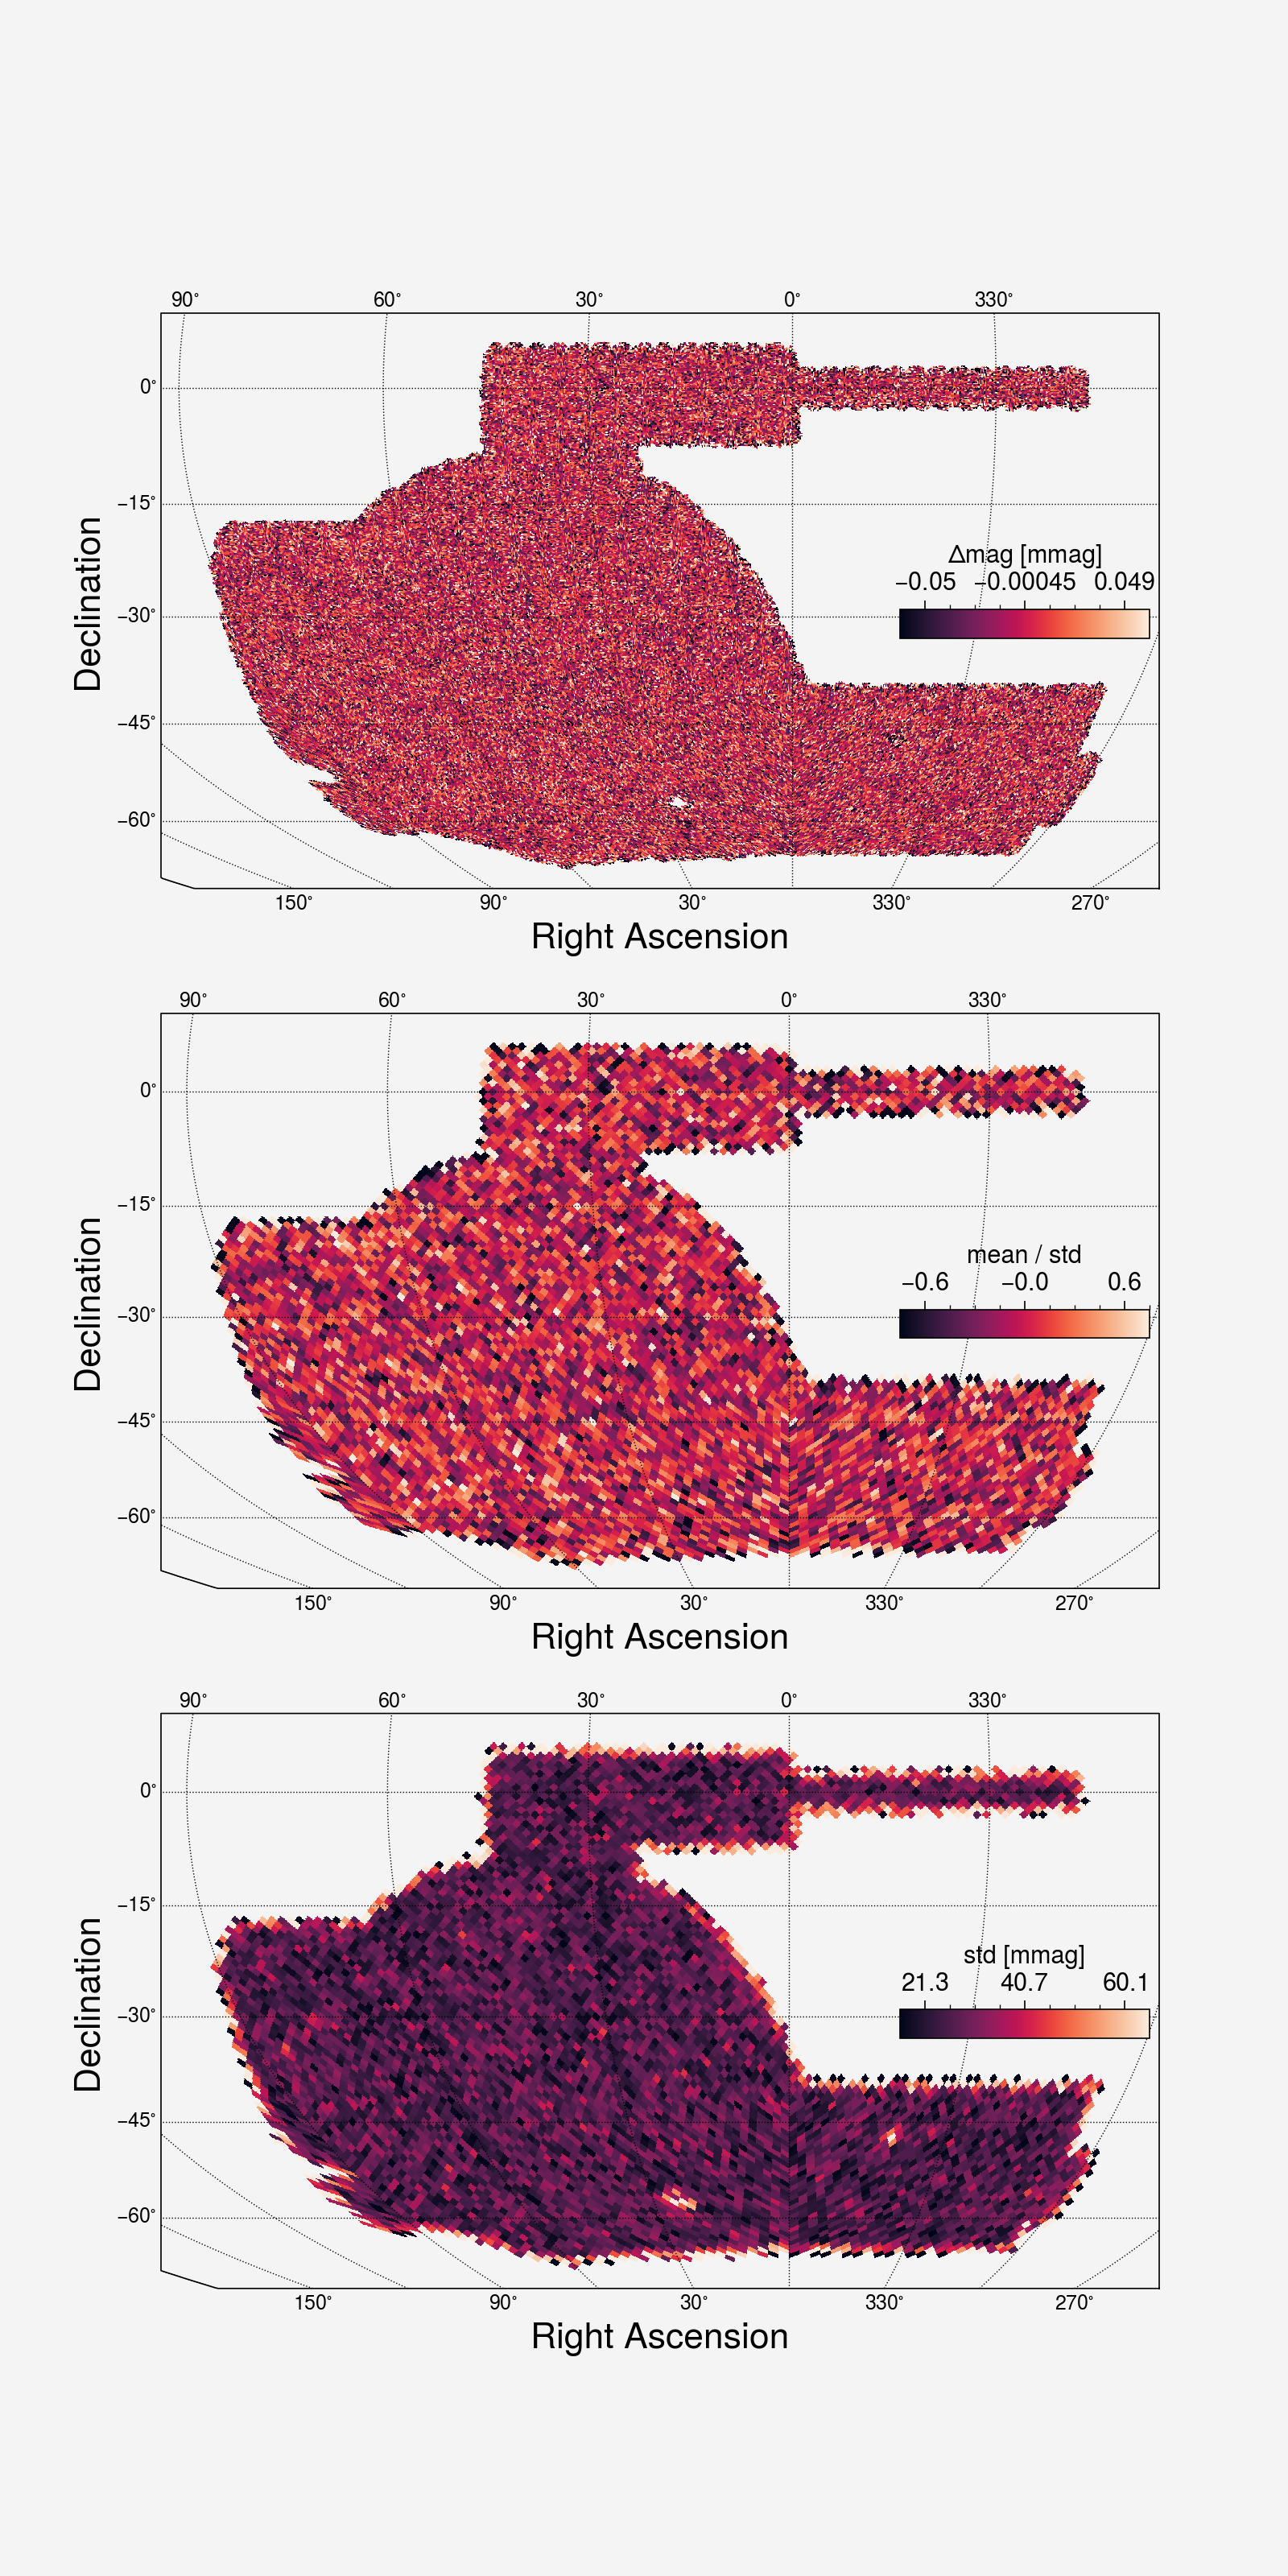

In [56]:
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(8, 16), squeeze=False)

mn_map = hmap.degrade(64, reduction="mean")
sd_map = hmap.degrade(64, reduction="std")
mean_sd = np.median(sd_map.get_values_pix(sd_map.valid_pixels))

sp = skyproj.McBrydeSkyproj(ax=axs[0, 0])
sp.draw_hspmap(hmap, cmap="rocket")
sp.draw_inset_colorbar(label="$\Delta mag$ [mmag]")

sp = skyproj.McBrydeSkyproj(ax=axs[1, 0])
sp.draw_hspmap(mn_map/mean_sd, cmap="rocket")
sp.draw_inset_colorbar(label="mean / std")

sp = skyproj.McBrydeSkyproj(ax=axs[2, 0])
sp.draw_hspmap(sd_map / 1e-3, cmap="rocket")
sp.draw_inset_colorbar(label="std [mmag]")

## straight gd

In [ ]:
alpha = 1e-8
pars = _guess(fd, 1e-5)
for i in range(100000):
    chi2, grad = compute_chi2_and_grad(pars, grad, **kwargs)
    pars -= alpha * grad
    if i % 10000 == 0:
        print(i, chi2)

## Try JAX w/ Scipy in Various Ways

In [ ]:
grad

In [ ]:
from functools import partial

@partial(jax.jit, static_argnames=[
    "nnight", 
    "nexp", 
    "nstar", 
    "inv_unight", 
    "istar", 
    "ied", 
    "isstar", 
    "star_obs", 
    "star_obs_err",
])
def _pred_star(
    pars, *, nnight, nexp, nstar, inv_unight, istar, ied, isstar, star_obs, star_obs_err
):
    zp_night = pars[0:nnight]
    zp_exp = pars[nnight:nnight+nexp]
    true_star = pars[nnight+nexp:]
    
    pred_zp = jnp.take(zp_night, jnp.array(list(inv_unight))) + zp_exp
    
    pred_star = jnp.concatenate(
        [
            true_star[jnp.array(list(istar))] 
            + pred_zp[jnp.array(list(ied))],
            true_star[isstar:isstar+1]
        ],
        axis=0,
    )
    return pred_star / jnp.array(list(star_obs_err))

@partial(jax.jit, static_argnames=[
    "nnight", 
    "nexp", 
    "nstar", 
    "inv_unight", 
    "istar", 
    "ied", 
    "isstar", 
    "star_obs", 
    "star_obs_err",
])
def _chi2_pred_star(
    pars, *, nnight, nexp, nstar, inv_unight, istar, ied, isstar, star_obs, star_obs_err
):
    pred_star = _pred_star(
        pars,
        nnight=nnight, 
        nexp=nexp, 
        nstar=nstar, 
        inv_unight=inv_unight, 
        istar=istar, 
        ied=ied, 
        isstar=isstar, 
        star_obs=star_obs, 
        star_obs_err=star_obs_err
    )
    return jnp.sum((jnp.array(list(star_obs)) / jnp.array(list(star_obs_err)) - pred_star)**2)

In [ ]:
data = fd

kwargs = dict(
    nnight=data["data"]["true_zp_night"].shape[0],
    nexp=data["data"]["true_zp_nse"].shape[0],
    nstar=data["data"]["true_star"].shape[0],
    inv_unight=tuple(data["data"]["inv_unight"].tolist()), 
    istar=tuple(data["data"]["istar"].tolist()), 
    ied=tuple(data["data"]["ied"].tolist()), 
    isstar=data["data"]["isstar"], 
    star_obs=tuple(data["data"]["star_obs"].tolist()), 
    star_obs_err=tuple(data["data"]["star_obs_err"].tolist()),
)

In [ ]:
_chi2_pred_star(_guess(fd, 1e-3), **kwargs)

In [ ]:
import jax.scipy.optimize


ofun = partial(_chi2_pred_star, **kwargs)

res = jax.scipy.optimize.minimize(ofun, _guess(fd, 1e-3), method="BFGS", tol=1e-1)

In [ ]:
from scipy.optimize import least_squares

In [ ]:
_chi_pred_star_grad = jax.jit(
    jax.jacobian(_chi_pred_star),
    static_argnames=[
        "nnight", 
        "nexp", 
        "nstar", 
        "inv_unight", 
        "istar", 
        "ied", 
        "isstar", 
        "star_obs", 
        "star_obs_err",
    ]
) 

In [ ]:
res = least_squares(
    _chi_pred_star,
    _guess(fd, 1e-2),
    kwargs=kwargs,
    verbose=2,
    jac=_chi_pred_star_grad,
    method="trf",
)

In [ ]:
res

In [ ]:
fd["data"]["true_zp_night"], fd["data"]["true_zp_nse"], fd["data"]["true_star"]

In [ ]:
res["x"]

In [ ]:
f = np.ones(10)

In [ ]:
jax.jacobian(_pred_star)(_guess(fd, 1e-3), **kwargs)